In [126]:
import tensorflow as tf
from tensorflow.keras import layers, activations, losses, Model, Input
from tensorflow.nn import leaky_relu
import numpy as np
from itertools import combinations
from tensorflow.keras.utils import plot_model, Progbar
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# model architecture
class RankNet(Model):
    def __init__(self):
        super().__init__()
        self.dense = [layers.Dense(16, activation=leaky_relu), layers.Dense(8, activation=leaky_relu)]
        self.o = layers.Dense(1, activation='linear')
        self.oi_minus_oj = layers.Subtract()
    
    def call(self, inputs):
        xi, xj = inputs
        densei = self.dense[0](xi)
        densej = self.dense[0](xj)
        for dense in self.dense[1:]:
            densei = dense(densei)
            densej = dense(densej)
        oi = self.o(densei)
        oj= self.o(densej)
        oij = self.oi_minus_oj([oi, oj])
        output = layers.Activation('sigmoid')(oij)
        return output
    
    def build_graph(self):
        x = [Input(shape=(10)), Input(shape=(10))]
        return Model(inputs=x, outputs=self.call(x))
    
def predict_ranking(model, docks):
    """
    Predict the ranking of docks using a trained RankNet model.
    
    Args:
        model (RankNet): A trained RankNet model.
        docks (np.array): A 2D numpy array where each row represents a dock's features.
    
    Returns:
        List[int]: The indices of the docks sorted by their predicted ranking.
    """
    # Number of docks
    n_docks = docks.shape[0]
    
    # Generate all pairs of docks
    dock_indices = list(range(n_docks))
    dock_pairs = list(combinations(dock_indices, 2))
    
    # Prepare input arrays for model prediction
    xi = np.array([docks[i] for i, j in dock_pairs])
    xj = np.array([docks[j] for i, j in dock_pairs])
    
    # Predict pairwise preferences
    pairwise_preds = model.predict([xi, xj])
    
    # Initialize score dictionary
    scores = {i: 0 for i in dock_indices}
    
    # Aggregate pairwise predictions into scores
    for (i, j), pred in zip(dock_pairs, pairwise_preds):
        if pred > 0.5:  # i is preferred over j
            scores[i] += 1
        else:           # j is preferred over i
            scores[j] += 1
    
    # Sort docks by their scores in descending order
    ranked_indices = sorted(scores.keys(), key=lambda x: scores[x], reverse=True)
    
    return ranked_indices

In [169]:

# generate data
nb_query = 20
### in each query number of docs can be diffrent
query = np.array([i+1 for i in range(nb_query) for x in range(10)])
### for each doc we can take some random features
doc_features = np.random.random((len(query), 10))

doc_scores = []

# Generate and store shuffled ranks for each query
for q in range(nb_query):
    ranks = np.arange(1, 11).astype(np.float32)
    np.random.shuffle(ranks)
    doc_scores.append(ranks)

# Convert the list of arrays to a NumPy array
doc_scores = np.concatenate(doc_scores)

# put data into pairs
xi = []
xj = []
pij = []
pair_id = []
pair_query_id = []
### for each query we must create all pairs
for q in np.unique(query):
    query_idx = np.where(query == q)[0]
    # print(query_idx)
    for pair_idx in combinations(query_idx, 2):
        pair_query_id.append(q)
        
        pair_id.append(pair_idx)
        i = pair_idx[0]
        j = pair_idx[1]
        xi.append(doc_features[i]) # features of first doc in pair
        xj.append(doc_features[j]) # features of second doc in pair
        
        
        if doc_scores[i] == doc_scores[j]:
            _pij = 0.5
        elif doc_scores[i] > doc_scores[j]:
            _pij = 1
        else: 
            _pij = 0
        pij.append(_pij)
        
xi = np.array(xi)
xj = np.array(xj)
pij = np.array(pij)
pair_query_id = np.array(pair_query_id)

xi_train, xi_test, xj_train, xj_test, pij_train, pij_test, pair_id_train, pair_id_test = train_test_split(
    xi, xj, pij, pair_id, test_size=0.2, stratify=pair_query_id)


In [170]:
doc_scores

array([ 8.,  7., 10.,  6.,  2.,  3.,  4.,  9.,  1.,  5.,  5.,  7.,  3.,
        2.,  6.,  9.,  8., 10.,  4.,  1.,  6., 10.,  1.,  7.,  8.,  4.,
        2.,  5.,  9.,  3.,  7.,  4.,  9., 10.,  5.,  2.,  1.,  8.,  6.,
        3.,  4.,  7.,  6.,  9.,  3.,  8.,  5.,  1., 10.,  2.,  6.,  8.,
        7.,  9.,  3.,  4.,  1., 10.,  5.,  2.,  9.,  7.,  5.,  1.,  2.,
        3.,  6.,  8.,  4., 10.,  8.,  1., 10.,  9.,  4.,  2.,  3.,  6.,
        7.,  5.,  4.,  5.,  2.,  7.,  6.,  3., 10.,  9.,  8.,  1.,  8.,
        7.,  4., 10.,  3.,  2.,  1.,  9.,  6.,  5.,  6., 10.,  3.,  2.,
        7.,  8.,  4.,  5.,  1.,  9.,  7.,  8., 10.,  5.,  3.,  4.,  1.,
        2.,  6.,  9.,  1.,  8.,  4.,  3.,  2.,  5., 10.,  6.,  7.,  9.,
        9.,  8.,  1.,  7.,  2.,  3.,  5.,  4., 10.,  6.,  1.,  2.,  7.,
        5.,  3.,  4.,  9.,  8., 10.,  6.,  5.,  8.,  6.,  2.,  1.,  4.,
        7.,  3., 10.,  9.,  1., 10.,  6.,  4.,  7.,  3.,  8.,  2.,  5.,
        9.,  4.,  7.,  9.,  2.,  5.,  8., 10.,  6.,  1.,  3.,  9

In [171]:
# train model using compile and fit
ranknet = RankNet()
ranknet.compile(optimizer='adam', loss='binary_crossentropy')
history = ranknet.fit([xi_train, xj_train], pij_train, epochs=20, batch_size=1, validation_data=([xi_test, xj_test], pij_test))

Epoch 1/20
720/720 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.6948 - val_loss: 0.6977
Epoch 2/20
720/720 ━━━━━━━━━━━━━━━━━━━━ 1s 724us/step - loss: 0.6885 - val_loss: 0.6944
Epoch 3/20
720/720 ━━━━━━━━━━━━━━━━━━━━ 1s 751us/step - loss: 0.6873 - val_loss: 0.6924
Epoch 4/20
720/720 ━━━━━━━━━━━━━━━━━━━━ 1s 742us/step - loss: 0.6815 - val_loss: 0.6889
Epoch 5/20
720/720 ━━━━━━━━━━━━━━━━━━━━ 1s 745us/step - loss: 0.6781 - val_loss: 0.6859
Epoch 6/20
720/720 ━━━━━━━━━━━━━━━━━━━━ 1s 750us/step - loss: 0.6685 - val_loss: 0.6859
Epoch 7/20
720/720 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.6708 - val_loss: 0.6835
Epoch 8/20
720/720 ━━━━━━━━━━━━━━━━━━━━ 1s 791us/step - loss: 0.6613 - val_loss: 0.6840
Epoch 9/20
720/720 ━━━━━━━━━━━━━━━━━━━━ 1s 772us/step - loss: 0.6641 - val_loss: 0.6942
Epoch 10/20
720/720 ━━━━━━━━━━━━━━━━━━━━ 1s 828us/step - loss: 0.6684 - val_loss: 0.6789
Epoch 11/20
720/720 ━━━━━━━━━━━━━━━━━━━━ 1s 947us/step - loss: 0.6537 - val_loss: 0.6832
Epoch 12/20
720/720 ━━━━━━━━━━━━━━

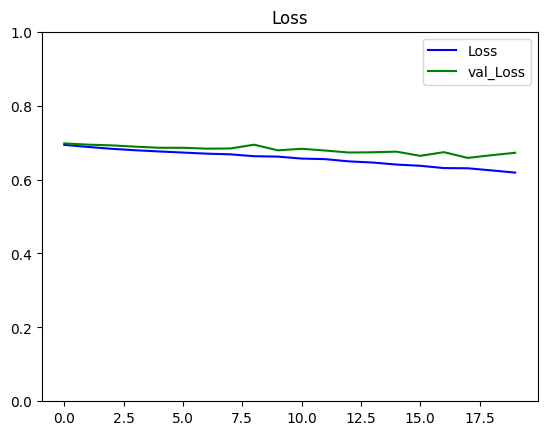

In [172]:
# function for plotting loss
def plot_metrics(train_metric, val_metric=None, metric_name=None, title=None, ylim=5):
    plt.title(title)
    plt.ylim(0,ylim)
    plt.plot(train_metric,color='blue',label=metric_name)
    if val_metric is not None: plt.plot(val_metric,color='green',label='val_' + metric_name)
    plt.legend(loc="upper right")

# plot loss history
plot_metrics(history.history['loss'], history.history['val_loss'], "Loss", "Loss", ylim=1.0)

In [187]:
def predict_ranking(model, docks):
    """
    Predict the ranking of docks using a trained RankNet model.
    
    Args:
        model (RankNet): A trained RankNet model.
        docks (np.array): A 2D numpy array where each row represents a dock's features.
    
    Returns:
        np.array: A NumPy array representing the predicted ranking of docks.
    """
    # Number of docks
    n_docks = docks.shape[0]
    
    # Generate all pairs of docks
    dock_indices = np.arange(n_docks)
    dock_pairs = np.array(list(combinations(dock_indices, 2)))
    
    # Prepare input arrays for model prediction
    xi = docks[dock_pairs[:, 0]]
    xj = docks[dock_pairs[:, 1]]
    
    # Predict pairwise preferences
    pairwise_preds = model.predict([xi, xj])
    
    # Initialize score array
    scores = np.zeros(n_docks)
    
    # Aggregate pairwise predictions into scores
    for (i, j), pred in zip(dock_pairs, pairwise_preds):
        if pred > 0.5:  # i is preferred over j
            scores[i] += 1
        else:           # j is preferred over i
            scores[j] += 1
    
    # Sort docks by their scores in descending order
    ranked_indices = np.argsort(-scores)  # Descending order
    
    return ranked_indices

In [195]:
import pandas as pd

# # Make predictions on the test data
# driver_a = np.ones((2,10))
# driver_b = np.ones((2,10)) + -1
# predictions = ranknet.predict([driver_a, driver_b])
# predictions

docks = np.random.rand(10, 10) 
# print(docks)
# doc_scores
# query
# docks

# ranking = predict_ranking(ranknet, docks)
# ranking
df_results = pd.DataFrame()

for q in np.unique(query):
    if q != 1:
        continue
    query_idx = np.where(query == q)[0]
    ranking = predict_ranking(ranknet, doc_features[query_idx])
    comparison = np.stack((ranking, doc_scores[query_idx]), axis = 1)
    print(comparison)

        

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
[[ 8.  8.]
 [ 2.  7.]
 [ 3. 10.]
 [ 0.  6.]
 [ 5.  2.]
 [ 9.  3.]
 [ 1.  4.]
 [ 7.  9.]
 [ 6.  1.]
 [ 4.  5.]]


In [160]:
xi_test.shape


(180, 10)

In [85]:
xj_test.shape

(410, 10)

In [104]:
import pandas as pd

x_all_test = np.vstack((xi_test, xj_test))
x_all_test 
check_df = pd.DataFrame(x_all_test, columns=[str(i) for i in range(1, 11)])
check_df.drop_duplicates()


,1,2,3,4,5,6,7,8,9,10
0,0.993847,0.319057,0.097252,0.788216,0.084758,0.520777,0.073787,0.065928,0.345493,0.050809
1,0.440636,0.539315,0.572966,0.814121,0.102193,0.623215,0.594918,0.638757,0.721550,0.472905
2,0.245963,0.585991,0.170838,0.818544,0.092318,0.609022,0.178915,0.012006,0.234004,0.969845
3,0.261121,0.589638,0.937703,0.460541,0.896647,0.436451,0.664211,0.208750,0.669538,0.926470
4,0.127805,0.184709,0.803842,0.976870,0.420374,0.016633,0.644816,0.035458,0.207999,0.924188
...,...,...,...,...,...,...,...,...,...,...
772,0.336772,0.599577,0.219799,0.213485,0.909376,0.735869,0.597533,0.320638,0.902255,0.420488
781,0.644840,0.893548,0.650571,0.373439,0.610802,0.886661,0.995396,0.635289,0.797047,0.562709
799,0.535393,0.282453,0.173462,0.424132,0.918610,0.954581,0.534859,0.114128,0.865750,0.992649
801,0.780753,0.731565,0.749342,0.757376,0.596491,0.197655,0.765120,0.630472,0.379705,0.487883


In [147]:
query
doc_scores

array([5., 6., 5., 8., 9., 9., 5., 8., 3., 8., 3., 1., 1., 9., 4., 8., 4.,
       6., 8., 0., 4., 6., 9., 0., 7., 2., 1., 0., 3., 2., 3., 5., 5., 5.,
       0., 6., 1., 0., 1., 8., 1., 2., 6., 4., 1., 1., 3., 2., 1., 7., 9.,
       7., 3., 7., 0., 6., 2., 0., 8., 3., 3., 4., 5., 7., 5., 2., 7., 6.,
       5., 6., 5., 5., 8., 7., 1., 0., 6., 2., 9., 0., 1., 0., 0., 8., 6.,
       2., 4., 4., 7., 7., 5., 0., 3., 5., 4., 9., 0., 6., 1., 9., 1., 6.,
       4., 5., 3., 0., 7., 9., 4., 4., 9., 3., 5., 2., 6., 2., 6., 8., 9.,
       6., 1., 9., 6., 0., 3., 1., 1., 0., 3., 1., 7., 9., 5., 7., 2., 9.,
       5., 2., 1., 4., 1., 5., 1., 8., 0., 1., 1., 3., 4., 1., 5., 4., 3.,
       4., 5., 1., 1., 8., 3., 2., 4., 3., 9., 2., 6., 0., 1., 3., 6., 6.,
       2., 6., 1., 1., 8., 9., 0., 1., 8., 5., 3., 1., 1., 2., 5., 5., 2.,
       7., 4., 4., 4., 3., 5., 9., 1., 3., 2., 5., 0., 9.], dtype=float32)

array([[0.85065851, 0.76645938, 0.46262373, ..., 0.2487295 , 0.54740904,
        0.75784825],
       [0.54802548, 0.96443264, 0.69201354, ..., 0.82412754, 0.19170757,
        0.01766016],
       [0.80006893, 0.13373313, 0.4116677 , ..., 0.94887944, 0.58042506,
        0.00518184],
       ...,
       [0.73633214, 0.81102309, 0.57044815, ..., 0.164273  , 0.37554393,
        0.7822381 ],
       [0.14265774, 0.26637338, 0.62889741, ..., 0.57457377, 0.99311713,
        0.75633511],
       [0.69297492, 0.42638288, 0.23095235, ..., 0.46151622, 0.19218285,
        0.79694347]])